In [1]:
import pandas as pd
import numpy as np

import os
import fnmatch
import json
import spacy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [90]:
PATH_DATA = '../Data/'

# Load files

## Citations

In [100]:
df_citations_wtopic = pd.read_pickle(PATH_DATA + 'df_citations_wtopic.pkl', compression='infer', storage_options=None)
topic_model_nosw_kmeans = pd.read_pickle(PATH_DATA + 'topic_model_nosw_kmeans.pkl', compression='infer', storage_options=None)

In [6]:
topic_list_cit = df_citations_wtopic[['topic_cam_kme','topic_cam_kme_kw']].drop_duplicates(subset='topic_cam_kme').sort_values('topic_cam_kme')
topic_list_cit.head()

,topic_cam_kme,topic_cam_kme_kw
0,0,"[faire, pouvoir, aller, devoir, an, falloir, a..."
23,1,"[police, violence, victime, tribunal, prison, ..."
20,2,"[président, élection, politique, parti, trump,..."
51,3,"[film, musique, histoire, artiste, art, cinéma..."
42,4,"[financier, économique, économie, entreprise, ..."


## Article

In [99]:
df_articles_wtopic = pd.read_pickle(PATH_DATA + 'df_articles_wtopic_per_article.pkl', compression='infer', storage_options=None)
topic_model_nosw_kmeans_art = pd.read_pickle(PATH_DATA + 'topic_model_nosw_kmeans_art.pkl', compression='infer', storage_options=None)

In [8]:
df_articles_wtopic['topic_cam_kmeans_article'] = df_articles_wtopic['topic_cam_kmeans_article'].apply(lambda x: ' '.join(x))

In [9]:
topic_list = df_articles_wtopic['topic_cam_kmeans_article'].unique()
topic_article_df = pd.DataFrame(topic_list)

In [10]:
def get_topic_numbers(x,topic_list):
    for i, topic in enumerate(topic_list):
        if x == topic:
            x = i
    return x

In [11]:
df_articles_wtopic['topic_cam_kmeans_article_num'] = df_articles_wtopic['topic_cam_kmeans_article'].apply(lambda x: get_topic_numbers(x,topic_list))

In [12]:
short_topic_list = []
for topic in topic_list:
    short_topic_list.append(' '.join(topic.split()[:3]))

short_topic_dict = {}
for i, topic in enumerate(short_topic_list):
    short_topic_dict[i] = topic
short_topic_df = pd.DataFrame.from_dict(short_topic_dict, orient='index')

Join both dataframes : 

In [13]:
df = df_citations_wtopic.merge(df_articles_wtopic, how ='left', left_on='externalid', right_on='externalid')

# Analyses

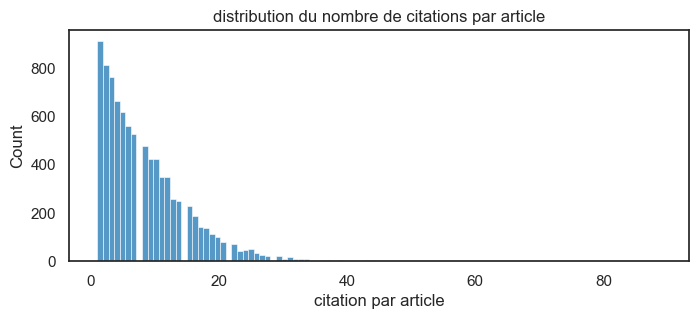

In [14]:
sns.set_theme(style="white", palette=None)
cit_par_art = df['externalid'].value_counts()
plt.figure(figsize=(8,3))
sns.histplot(cit_par_art)
plt.title('distribution du nombre de citations par article')
plt.xlabel('citation par article')
plt.show()

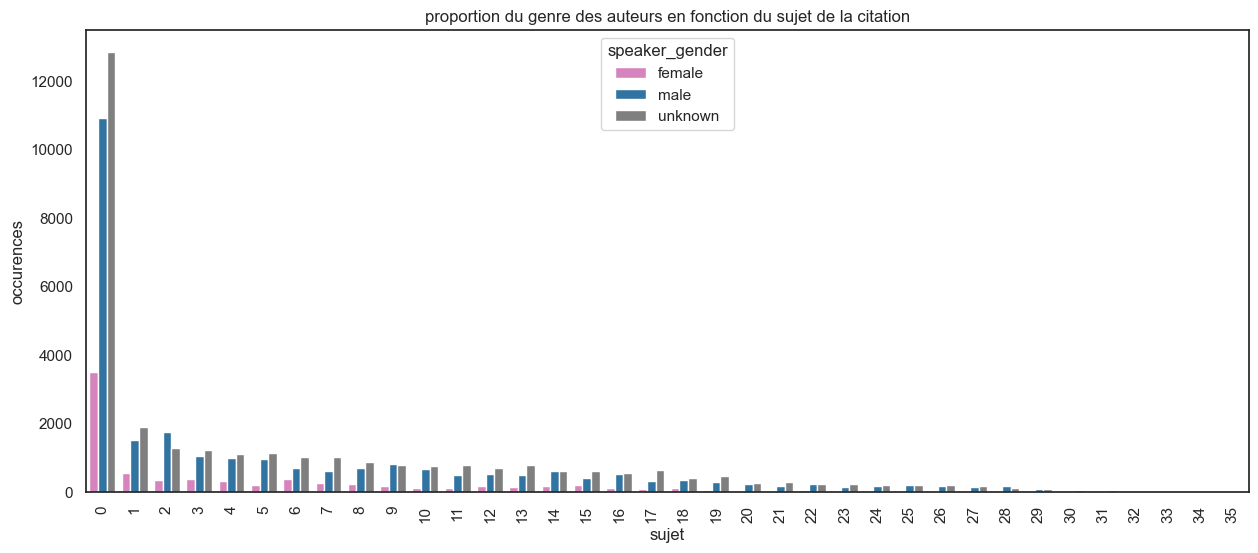

In [15]:
grouped = df.groupby(['topic_cam_kme','speaker_gender'])['speaker'].count()
grouped = grouped.to_frame()
grouped.reset_index(inplace=True)
plt.figure(figsize=(15,6))
plt.title('proportion du genre des auteurs en fonction du sujet de la citation')
sns.barplot(x='topic_cam_kme', y="speaker", hue="speaker_gender", data=grouped, palette=["C6", "C0", "C7"])
plt.xticks(rotation = 90)
plt.xlabel('sujet')
plt.ylabel('occurences')
plt.show()

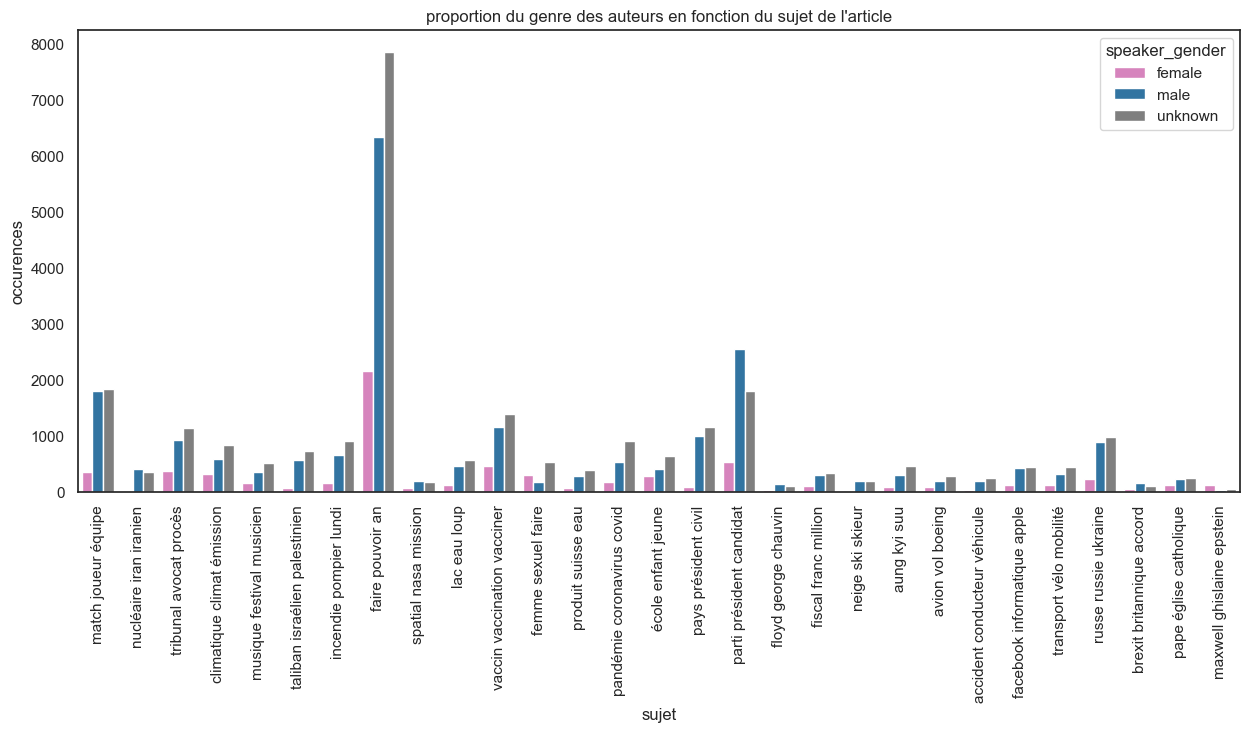

In [16]:
grouped = df.groupby(['topic_cam_kmeans_article_num','speaker_gender'])['speaker'].count()
grouped = grouped.to_frame()
grouped.reset_index(inplace=True)
fig, ax = plt.subplots(1,1,figsize=(15,6))
plt.title('proportion du genre des auteurs en fonction du sujet de l\'article')
sns.barplot(x='topic_cam_kmeans_article_num', y="speaker", hue="speaker_gender", data=grouped, palette=["C6", "C0", "C7"])
a=ax.get_xticks().tolist()
a=short_topic_list
plt.xticks(rotation = 90)
plt.xlabel('sujet')
plt.ylabel('occurences')
ax.set_xticklabels(a)
plt.show()

In [17]:
# topic maxwell ghislaine epstein
print(len(df[df['topic_cam_kmeans_article_num']== 28]['quote']))
print(df[df['topic_cam_kmeans_article_num']== 28]['quote'].duplicated().sum())

223
52


In [18]:
# topic femme sexuel faire
print(len(df[df['topic_cam_kmeans_article_num']== 11]['quote']))
print(df[df['topic_cam_kmeans_article_num']== 11]['quote'].duplicated().sum())

1084
207


In [19]:
duplicate_count = []
for i in range(29):
    duplicate_count.append(df[df['topic_cam_kmeans_article_num']== i]['quote'].duplicated().sum()/len(df[df['topic_cam_kmeans_article_num']== i]['quote']))

In [20]:
prop_df = pd.DataFrame(duplicate_count)
prop_df['topic'] = prop_df.index
prop_df.rename(columns={0: "proportion"},inplace=True)

In [21]:
len(short_topic_list)

29

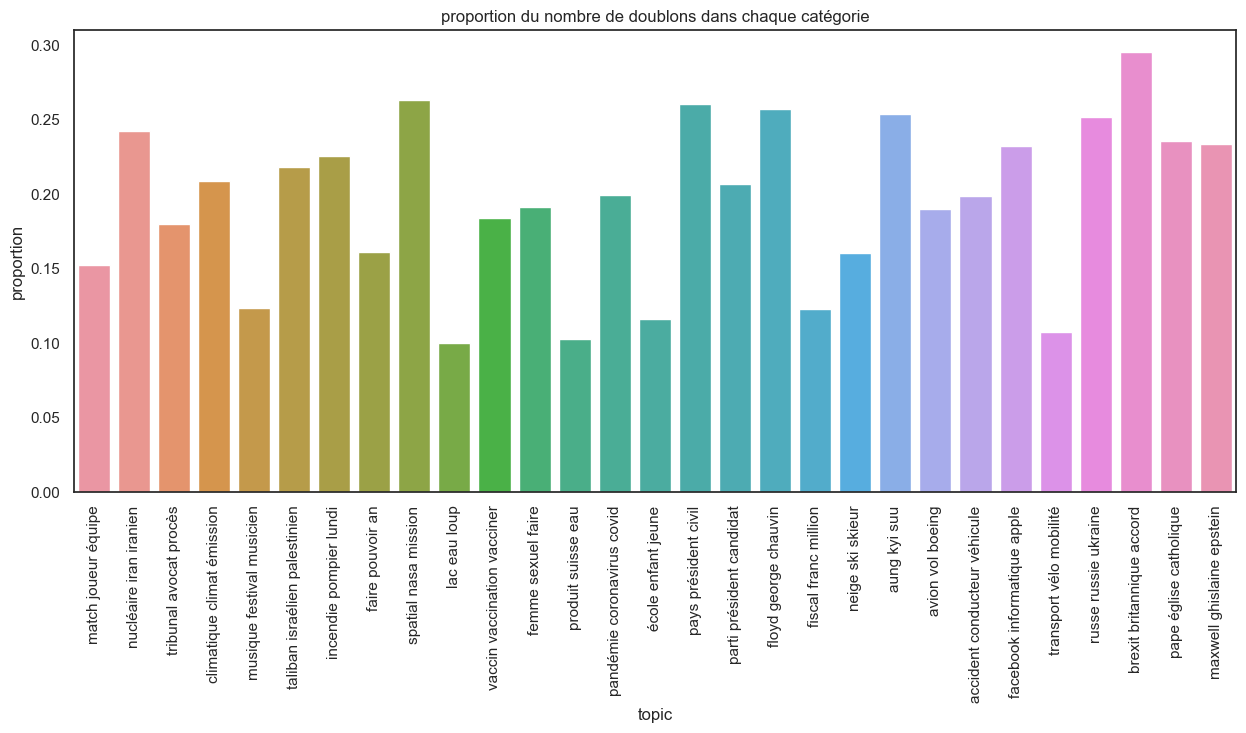

In [47]:
fig, ax = plt.subplots(1,1,figsize=(15,6))
sns.barplot(x='topic', y='proportion', data=prop_df)
a=ax.get_xticks().tolist()
a=short_topic_list
plt.xticks(rotation = 90)
plt.title('proportion du nombre de doublons dans chaque catégorie')
ax.set_xticklabels(a)
# plt.xlabel('sujet')
# plt.ylabel('occurences')
plt.show()

In [24]:
duplicate_proportion_gender = {}
duplicate_proportion_gender['male'] = (df[df['quote'].duplicated()]['speaker_gender'] == 'male' ).sum() / (df['speaker_gender'] == 'male' ).sum()
duplicate_proportion_gender['female'] = (df[df['quote'].duplicated()]['speaker_gender'] == 'female' ).sum() / (df['speaker_gender'] == 'female' ).sum()
duplicate_proportion_gender['unknown'] = (df[df['quote'].duplicated()]['speaker_gender'] == 'unknown' ).sum() / (df['speaker_gender'] == 'unknown' ).sum()

In [25]:
duplicate_proportion_gender_df = pd.DataFrame.from_dict(duplicate_proportion_gender,orient='index')
duplicate_proportion_gender_df.reset_index(inplace=True)
duplicate_proportion_gender_df.rename(columns={0: "proportion",'index': "gender"},inplace=True)
duplicate_proportion_gender_df.head()

,gender,proportion
0,male,0.330067
1,female,0.307524
2,unknown,0.337922


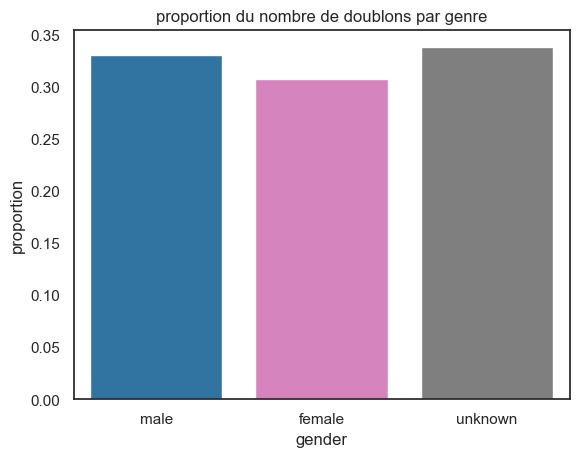

In [26]:
sns.barplot(x = 'gender',y='proportion',data = duplicate_proportion_gender_df, palette=["C0", "C6", "C7"])
plt.title('proportion du nombre de doublons par genre')
plt.show()

## Topic russie ukraine

In [27]:
short_topic_df.loc[25]

0    russe russie ukraine
Name: 25, dtype: object

In [28]:
(df['topic_cam_kmeans_article_num']==25).sum()

2302

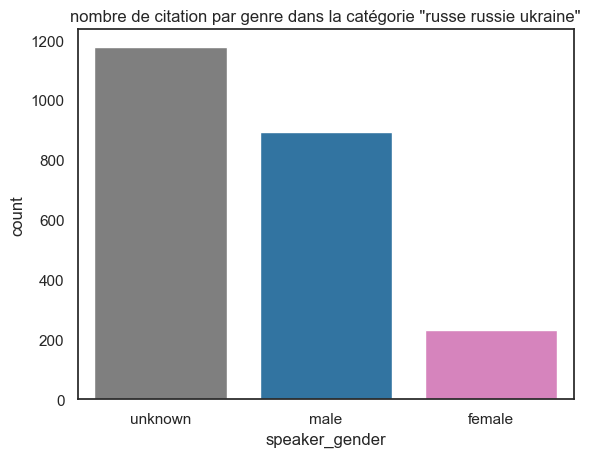

In [29]:
sns.countplot(x = 'speaker_gender', data = df[df['topic_cam_kmeans_article_num']==25], palette=[ "C7", "C0","C6"])
plt.title('nombre de citation par genre dans la catégorie "russe russie ukraine"')
plt.show()

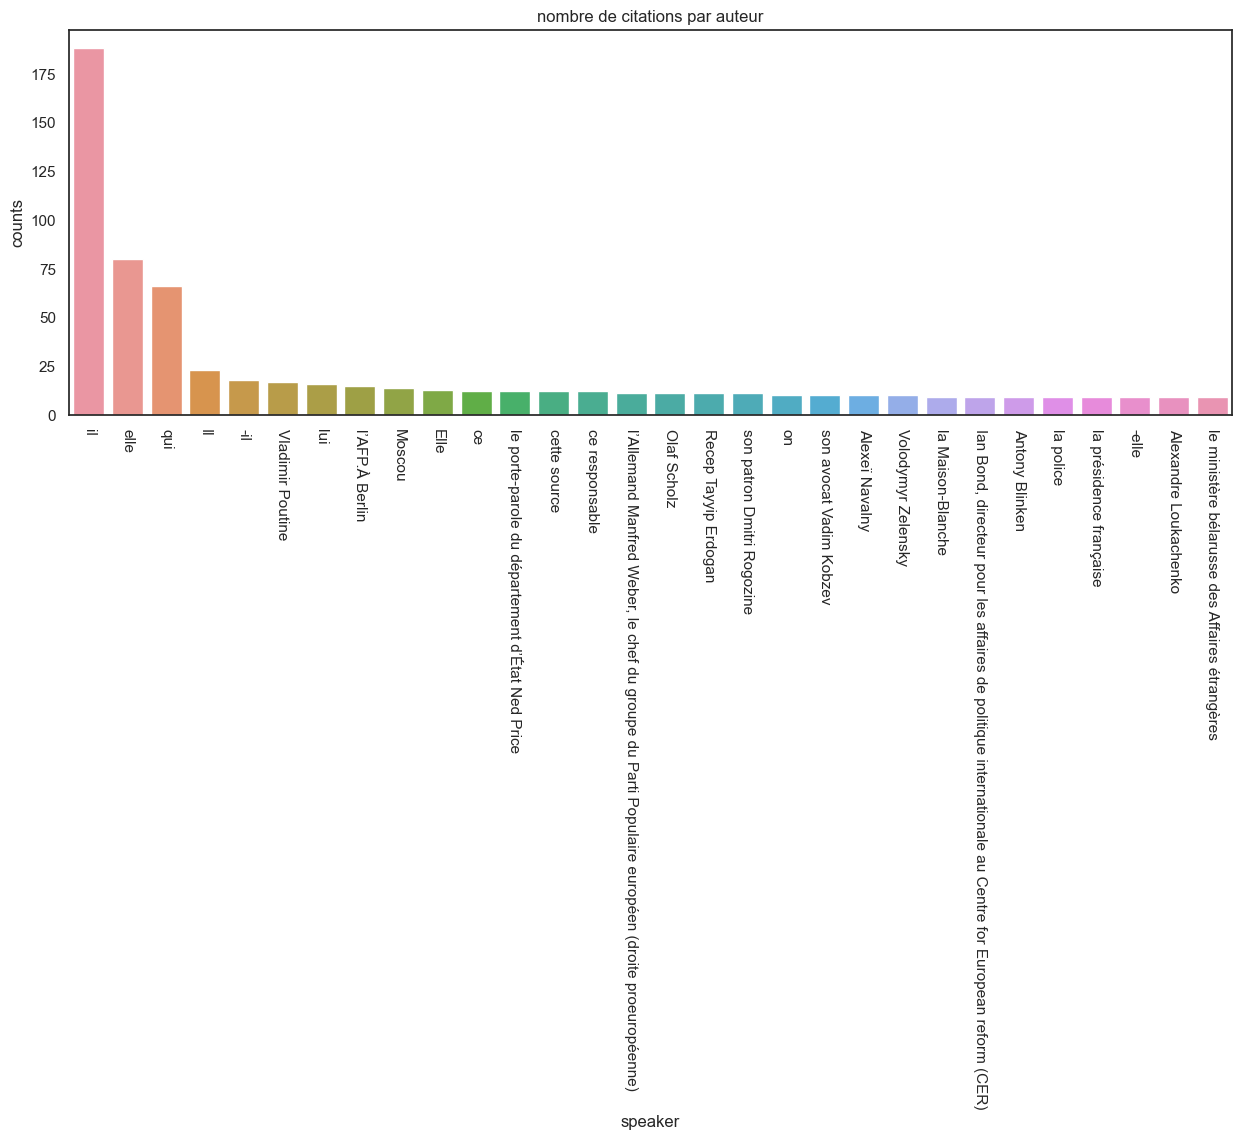

In [30]:
speaker_topic_ukr = df[df['topic_cam_kmeans_article_num']==25].groupby('speaker')['speaker'].count().to_frame()
speaker_topic_ukr.rename(columns={'speaker': "counts"},inplace=True)
speaker_topic_ukr.sort_values('counts',ascending=False).head(30)
plt.figure(figsize=(15,5))
plt.title('nombre de citations par auteur')
sns.barplot(x='speaker',y='counts',data=speaker_topic_ukr.sort_values('counts',ascending=False).reset_index()[:30])
plt.xticks(rotation = -90)
plt.show()

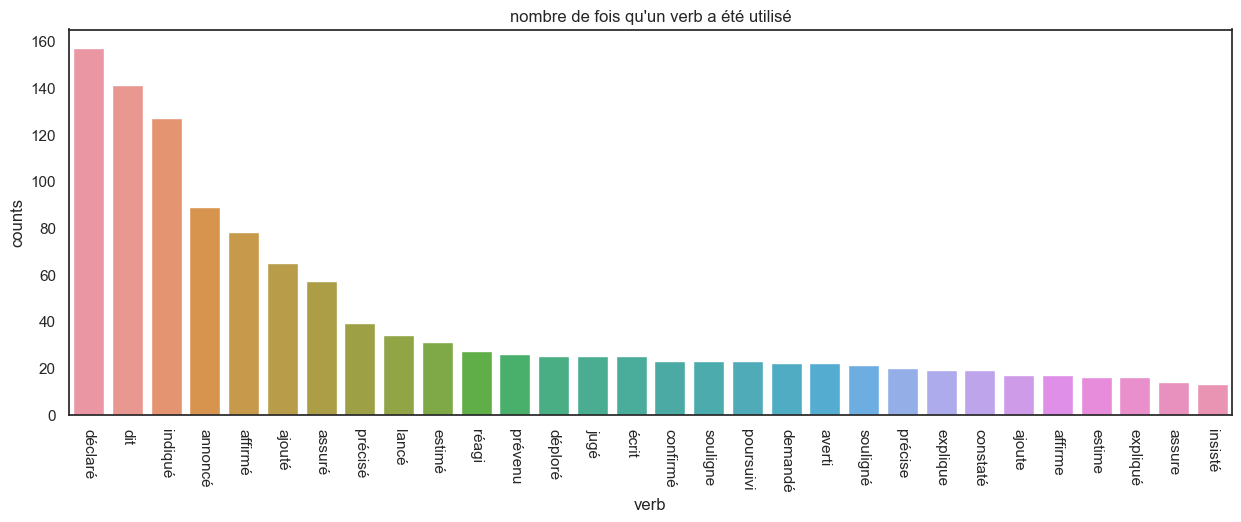

In [34]:
# TO DO : lemmatizer les verbes avant de faire ce plot
speaker_topic_ukr = df[df['topic_cam_kmeans_article_num']==25].groupby('verb')['speaker'].count().to_frame()
speaker_topic_ukr.rename(columns={'speaker': "counts"},inplace=True)
speaker_topic_ukr.sort_values('counts',ascending=False).head(30)
plt.figure(figsize=(15,5))
sns.barplot(x='verb',y='counts',data=speaker_topic_ukr.sort_values('counts',ascending=False).reset_index()[:30])
plt.title('nombre de fois qu\'un verb a été utilisé')
plt.xticks(rotation = -90)
plt.show()

In [35]:
verbs_gender = df[df['topic_cam_kmeans_article_num']==25].groupby(['verb','speaker_gender']).count()['speaker'].reset_index(level=[0,1])
verbs_fem = verbs_gender[verbs_gender['speaker_gender'] == 'female'].sort_values('speaker',ascending=False)[:10]
verbs_mal = verbs_gender[verbs_gender['speaker_gender'] == 'male'].sort_values('speaker',ascending=False)[:10]
verbs_mal['speaker'] = verbs_mal['speaker'].apply(lambda x : -x)
verbs_fem = verbs_fem.append(verbs_mal)
verbs_fem.reset_index(inplace=True)
verbs_fem.reset_index(inplace=True)

C:\Users\Younes\AppData\Local\Temp/ipykernel_3128/1229492881.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a, rotation='vertical')


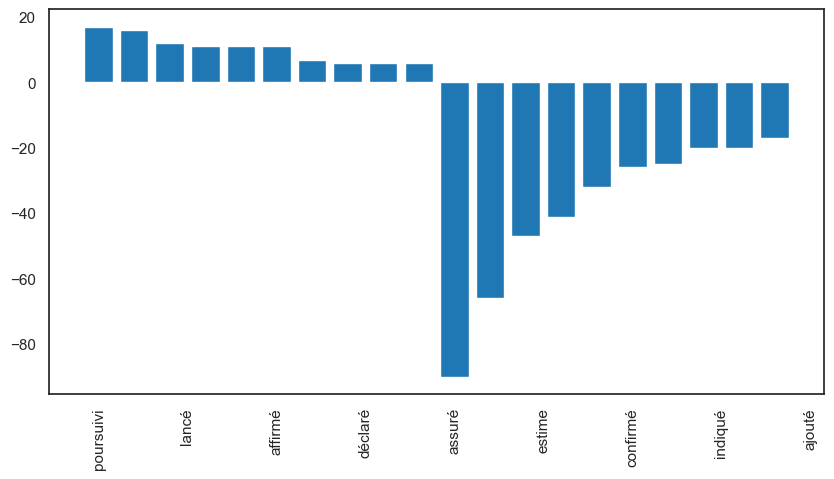

In [36]:
fig, ax = plt.subplots(1,1,figsize = (10,5))
plt.bar(verbs_fem['level_0'], verbs_fem['speaker'].to_list())

a=ax.get_xticks().tolist()
a=verbs_fem['verb'].to_list()
ax.set_xticklabels(a, rotation='vertical')
# plt.xticks(rotation = -90)
# plt.xticks(a)
plt.show()

## Topic maxwell gislain

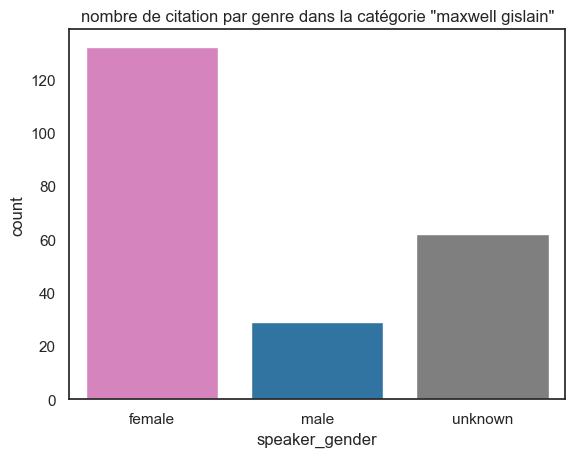

In [37]:
sns.countplot(x = 'speaker_gender', data = df[df['topic_cam_kmeans_article_num']==28], palette=[ "C6", "C0", "C7"])
plt.title('nombre de citation par genre dans la catégorie "maxwell gislain"')
plt.show()

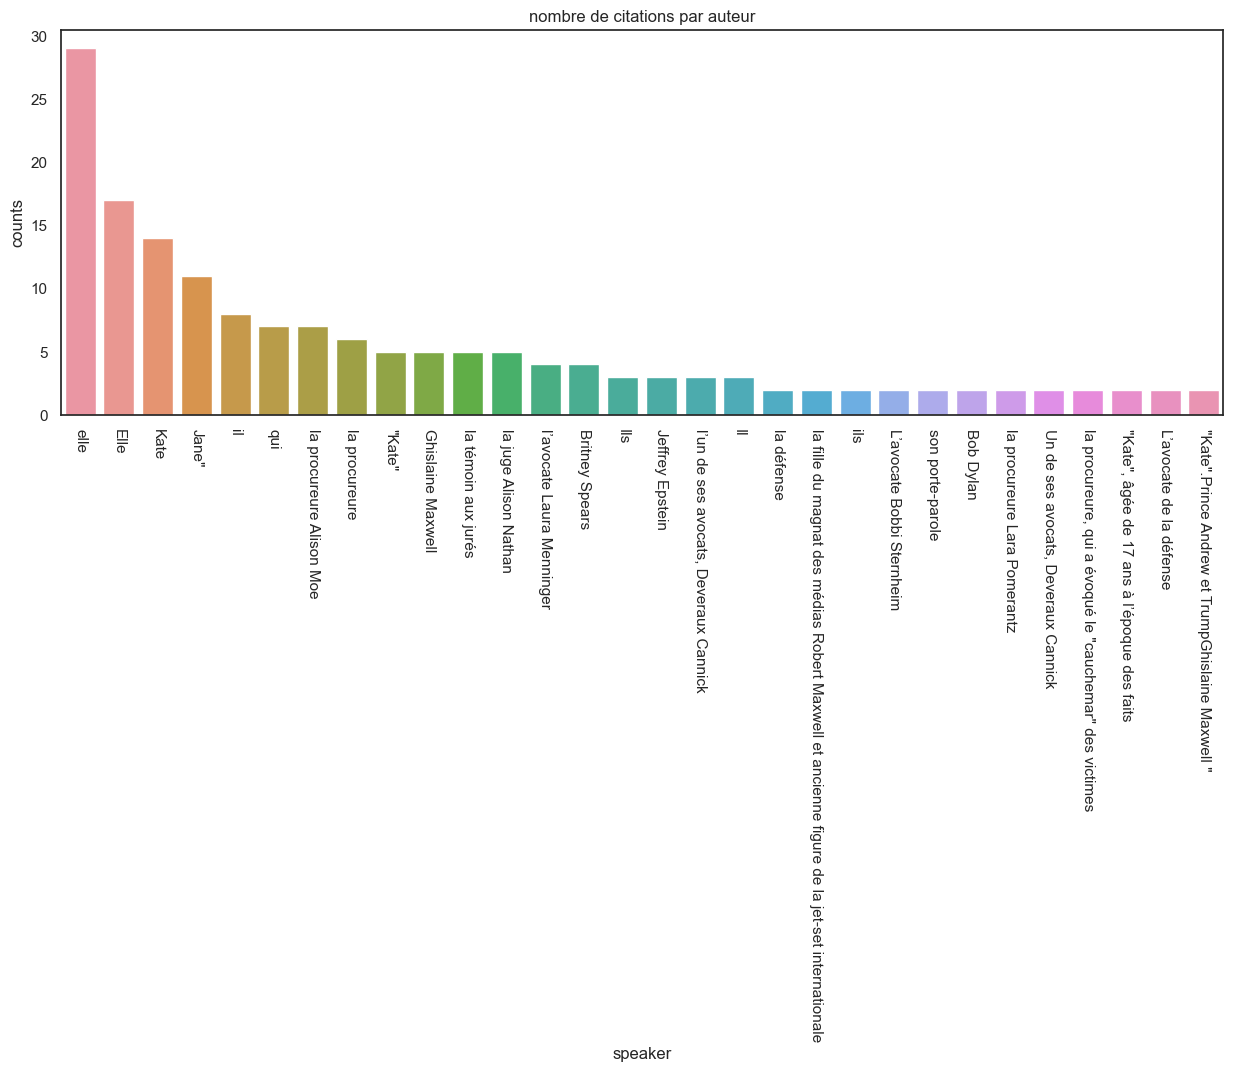

In [38]:
speaker_topic_ukr = df[df['topic_cam_kmeans_article_num']==28].groupby('speaker')['speaker'].count().to_frame()
speaker_topic_ukr.rename(columns={'speaker': "counts"},inplace=True)
speaker_topic_ukr.sort_values('counts',ascending=False).head(30)
plt.figure(figsize=(15,5))
plt.title('nombre de citations par auteur')
sns.barplot(x='speaker',y='counts',data=speaker_topic_ukr.sort_values('counts',ascending=False).reset_index()[:30])
plt.xticks(rotation = -90)
plt.show()

In [39]:
print(len(df[df['topic_cam_kmeans_article_num']== 28]['quote']))
print(df[df['topic_cam_kmeans_article_num']== 28]['quote'].duplicated().sum())

223
52


In [40]:
ratios = {}
for speaker in df[df['topic_cam_kmeans_article_num']== 28]['speaker'].unique():
    quote_num = len(df[df['topic_cam_kmeans_article_num']== 28][df[df['topic_cam_kmeans_article_num']== 28]['speaker'] == speaker]['quote'])
    duplicates = df[df['topic_cam_kmeans_article_num']== 28][df[df['topic_cam_kmeans_article_num']== 28]['speaker'] == speaker]['quote'].duplicated().sum()
    ratio = duplicates/(quote_num+1e-4)
    ratios[speaker]=ratio

In [41]:
proportion_duplicates = pd.DataFrame.from_dict(ratios,orient='index').reset_index()
proportion_duplicates.rename(columns={'index': "speaker",0: "proportion"},inplace=True)
proportion_duplicates.sort_values('proportion',ascending=False,inplace=True)

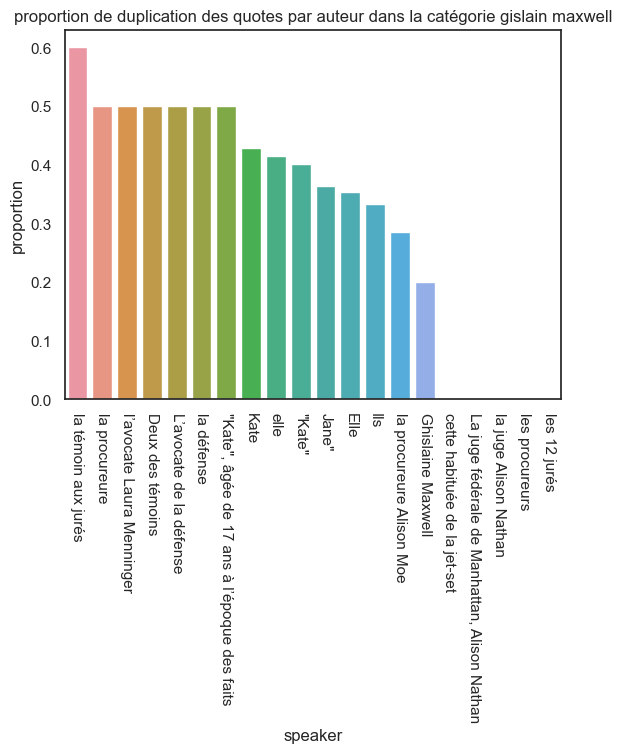

In [42]:
sns.barplot(x='speaker',y='proportion',data=proportion_duplicates[:20])
plt.title('proportion de duplication des quotes par auteur dans la catégorie gislain maxwell')
plt.xticks(rotation = -90)
plt.show()

In [48]:
ratios = {}
for speaker in df[df['topic_cam_kmeans_article_num']== 28]['speaker'].unique():
    quote_num = len(df[df['topic_cam_kmeans_article_num']== 28][df[df['topic_cam_kmeans_article_num']== 28]['speaker'] == speaker]['quote'])
    duplicates = df[df['topic_cam_kmeans_article_num']== 28][df[df['topic_cam_kmeans_article_num']== 28]['speaker'] == speaker]['quote'].duplicated().sum()
    ratio = duplicates/(quote_num+1e-4)
    gender = df[df['topic_cam_kmeans_article_num']== 28][df[df['topic_cam_kmeans_article_num']== 28]['speaker']==speaker]['speaker_gender']
    if len(gender)>0:
        gender = gender.iloc[0]
    ratios[speaker]=[ratio,gender]

In [49]:
proportion_duplicates = pd.DataFrame.from_dict(ratios,orient='index').reset_index()
proportion_duplicates.rename(columns={'index': "speaker",0: "proportion",1:'gender'},inplace=True)
proportion_duplicates.sort_values('proportion',ascending=False,inplace=True)

In [67]:
proportion_duplicates

,speaker,proportion,gender
4,la témoin aux jurés,0.599988,unknown
43,la procureure,0.499992,female
46,l’avocate Laura Menninger,0.499988,female
44,Deux des témoins,0.499975,unknown
47,L’avocate de la défense,0.499975,unknown
...,...,...,...
32,ils,0.000000,male
33,François Zimeray,0.000000,male
1,la fille du magnat des médias Robert Maxwell e...,0.000000,male
36,"""Kate"".Prince Andrew et TrumpGhislaine Maxwell """,0.000000,female


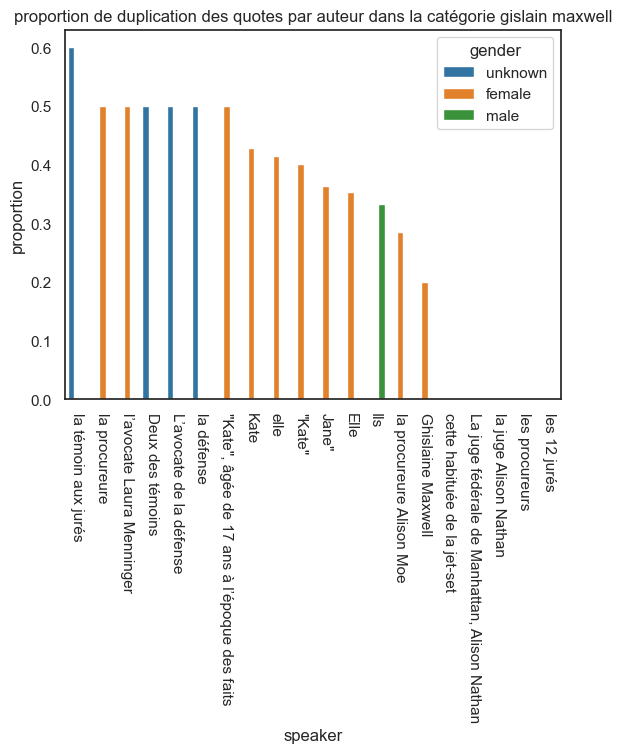

In [66]:
sns.barplot(x='speaker',y='proportion',hue='gender',data=proportion_duplicates[:20])
plt.title('proportion de duplication des quotes par auteur dans la catégorie gislain maxwell')
plt.xticks(rotation = -90)
plt.show()

# Other

## Visu only using 'section' column

In [91]:
df_citations = pd.read_csv(PATH_DATA+'citations.csv', index_col=0)

In [92]:
df_articles = pd.read_csv('../Data/articles_data.tsv', sep='\t') 

In [93]:
def barplot_custom(df):
    f, ax = plt.subplots(figsize = (6,15))
    sns.set_color_codes('pastel')

    sns.barplot(x = 'counts', y = 'section' , data = df[0:50],
                label = 'test', color = 'b', edgecolor = 'w')

    sns.despine(left = True, bottom = True)
    plt.show()

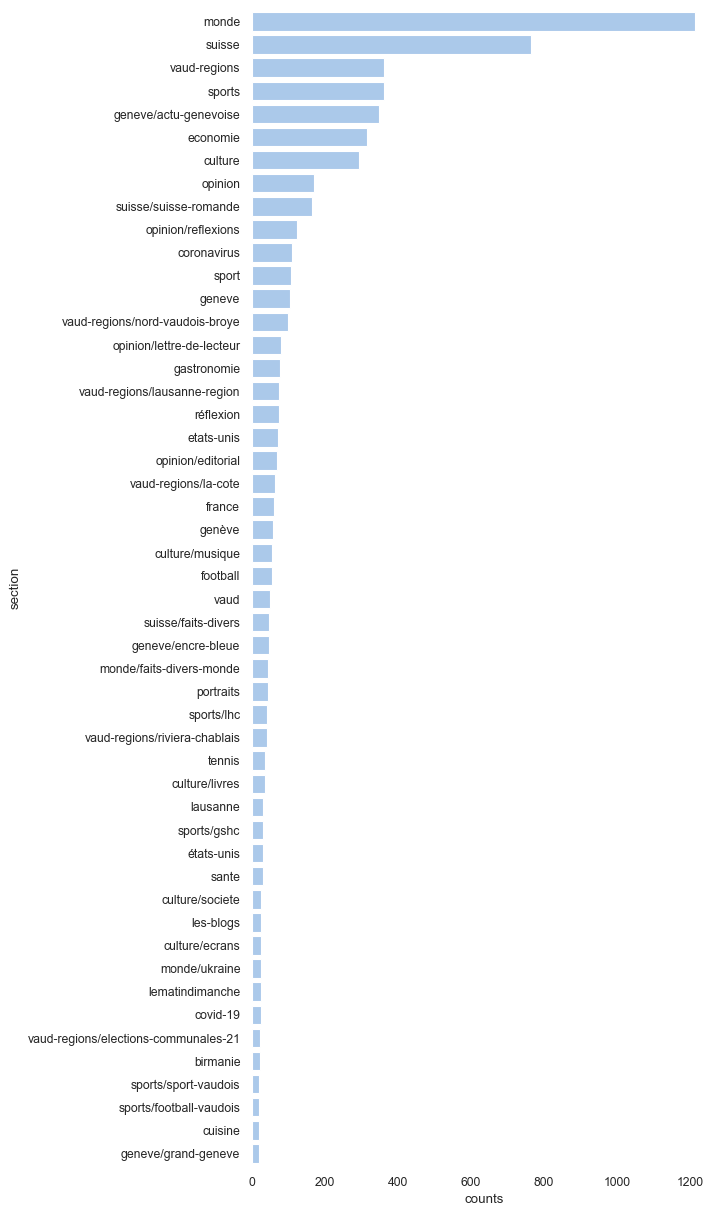

In [94]:
sns.set_context('paper')
article_freq = df_articles.groupby(['section']).size().reset_index(name='counts').sort_values('counts', axis=0, ascending=False)
barplot_custom(article_freq)

In [95]:
ext_id_section = df_articles[['externalid','section']]

In [96]:
gender_section_df = df_citations.merge(ext_id_section, how='left', on=None, left_on='externalid', right_on='externalid', left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

In [97]:
sections_male = gender_section_df[['speaker_gender','section']][gender_section_df['speaker_gender'] == 'male'].groupby(['section']).size().reset_index(name='counts').sort_values('counts', axis=0, ascending=False)
sections_female = gender_section_df[['speaker_gender','section']][gender_section_df['speaker_gender'] == 'female'].groupby(['section']).size().reset_index(name='counts').sort_values('counts', axis=0, ascending=False)
sections_unk = gender_section_df[['speaker_gender','section']][gender_section_df['speaker_gender'] == 'unknown'].groupby(['section']).size().reset_index(name='counts').sort_values('counts', axis=0, ascending=False)

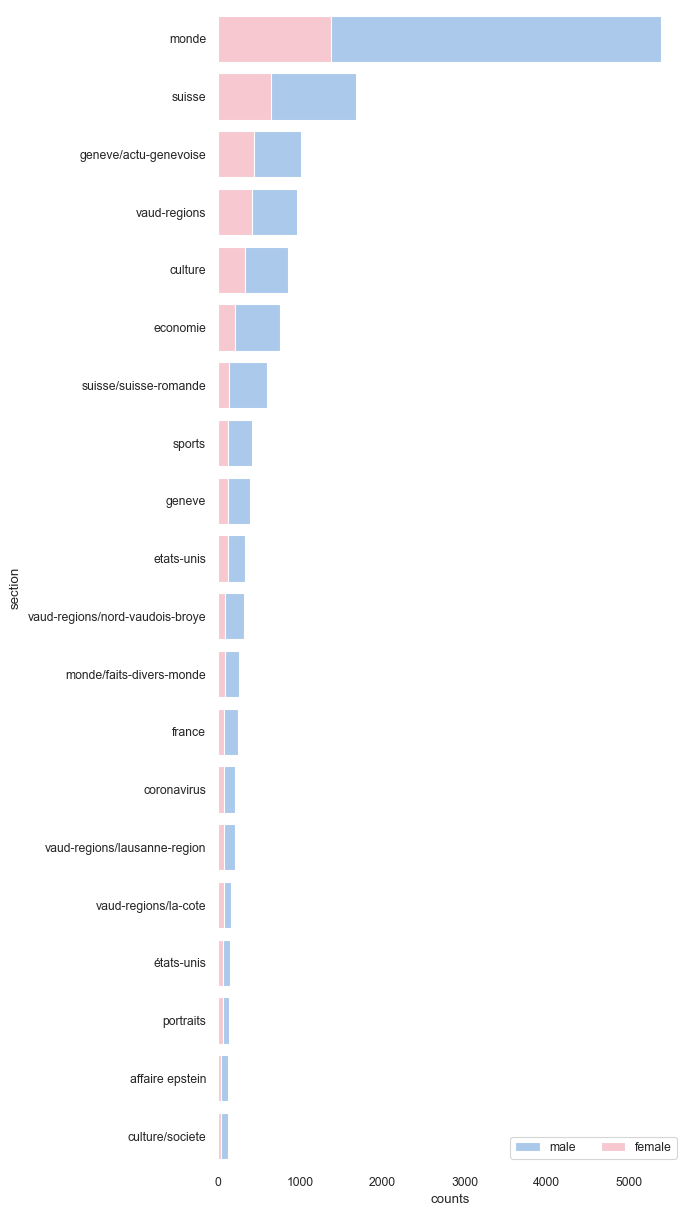

In [98]:
sns.set_context('paper')

f, ax = plt.subplots(figsize = (6,15))

sns.set_color_codes('pastel')

sns.barplot(x = 'counts', y = 'section', data = sections_male[0:20],
            label = 'male', color = 'b', edgecolor = 'w')
sns.set_color_codes('muted')

sns.barplot(x = 'counts', y = 'section', data = sections_female[0:20],
            label = 'female', color = 'pink', edgecolor = 'w')

ax.legend(ncol = 2, loc = 'lower right')
sns.despine(left = True, bottom = True)
plt.show()

## duplicates

In [71]:
df_citations_wtopic.duplicated(subset=['quote']).sum()

23957

In [72]:
b = df_citations_wtopic[df_citations_wtopic.duplicated(subset='quote',keep='first')].loc[4185]['quote']

In [73]:
a = df_citations_wtopic[df_citations_wtopic.duplicated(subset='quote',keep='first')].loc[10393]['quote'] 

In [78]:
# df_citations_wtopic[df_citations_wtopic.duplicated(subset='quote',keep='first')].head(20)

In [75]:
df_citations_wtopic[df_citations_wtopic['quote'].apply(lambda x: x== a)]

,speaker,speaker_index,quote,quote_index,verb,verb_index,quote_token_count,quote_type,is_floating_quote,reference,speaker_gender,externalid,topic_cam_kme,topic_cam_kme_kw
7564,"BioNTech et Pfizer, les fabricants du principa...","(4264, 4344)",que ce dernier était efficace contre la mutati...,"(4356, 4500)",assuré,"(4349, 4355)",22,SVC,False,"BioNTech et Pfizer, les fabricants du principa...",unknown,269990435348,13,"[covid, coronavirus, 19, virus, pandémie, cas,..."
10393,"BioNTech et Pfizer, les fabricants du principa...","(3916, 3996)",que ce dernier était efficace contre la mutati...,"(4008, 4152)",assuré,"(4001, 4007)",22,SVC,False,"BioNTech et Pfizer, les fabricants du principa...",unknown,340199559559,13,"[covid, coronavirus, 19, virus, pandémie, cas,..."


In [76]:
df_citations_wtopic[df_citations_wtopic['quote'].apply(lambda x: x== b)]

,speaker,speaker_index,quote,quote_index,verb,verb_index,quote_token_count,quote_type,is_floating_quote,reference,speaker_gender,externalid,topic_cam_kme,topic_cam_kme_kw
1614,Brittany Higgins,"(1058, 1074)",avoir été violée en 2019 par un collègue dans ...,"(1101, 1244)",affirmé,"(1077, 1084)",27,SVC,False,Brittany Higgins,female,137626322981,1,"[police, violence, victime, tribunal, prison, ..."
4185,Brittany Higgins,"(986, 1002)",avoir été violée en 2019 par un collègue dans ...,"(1029, 1172)",affirmé,"(1005, 1012)",27,SVC,False,Brittany Higgins,female,192867231504,1,"[police, violence, victime, tribunal, prison, ..."
21097,qui,"(1311, 1314)",avoir été violée en 2019 par un collègue dans ...,"(1341, 1484)",affirmé,"(1317, 1324)",27,SVC,False,qui,unknown,42263682,1,"[police, violence, victime, tribunal, prison, ..."
21111,Brittany Higgins,"(1350, 1366)",avoir été violée en 2019 par un collègue dans ...,"(1393, 1536)",affirmé,"(1369, 1376)",27,SVC,False,Brittany Higgins,female,42263700,1,"[police, violence, victime, tribunal, prison, ..."
